In [28]:
from pathways.scenarios import run_scenarios, load_scenario_table
from pathways.simulation import load_configuration
from pathways.outputs import save_scenario_result_to_pandas

In [32]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [43]:
from pathlib import Path
datadir = Path("tests/test_summaries")
basic_config = load_configuration(datadir / "config.yml")
scenario_table = load_scenario_table(datadir / "validation_scenarios.csv")

In [44]:
# Separate the scenarios by validation category (infestation, sampling, and outcomes)
infest_validation_scenarios = scenario_table[0:16]
sample_validation_scenarios = scenario_table[16:40]
outcome_validation_scenarios = scenario_table[40:80]

# Infestation validation

### Test 1: Simulate 10 shipments with 10 boxes each (200 stems/box).
Check infestation rates and pest arrangement using combinations of:
* Fixed infestation rates - fixed values of 0.01, 0.1, 0.2
* Infestation unit - box or stem
* Pest arrangement - random or clustered (box infestation unit: 2 boxes max infested units, stem infestation unit: 200 stems max infested units and 400 stems max width)

### Test 2: Simulate 1000 shipments with 100 boxes each (200 stems/box), repeat for 20 iterations.
Check infestation rates using combinations of::
* Stochastic infestation rates - beta probability distribution using parameters [0.0194628, 2.7609372] (mean = 0.007, sd = 0.05)
* Infestation unit - box or stem
* Pest arrangement - random or clustered (box infestation unit: 2 boxes max infested units, stem infestation unit: 400 stems max infested units and 400 stems max width)

In [5]:
# Run Test 1
num_shipments_1 = 10
infest_validation_results_1, infest_validation_details_1 = run_scenarios(
    config=basic_config,
    scenario_table=infest_validation_scenarios[0:12],
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments_1,
    detailed=True,
)

Running scenario: infest_validation_1
Running scenario: infest_validation_2
Running scenario: infest_validation_3
Running scenario: infest_validation_4
Running scenario: infest_validation_5
Running scenario: infest_validation_6
Running scenario: infest_validation_7
Running scenario: infest_validation_8
Running scenario: infest_validation_9
Running scenario: infest_validation_10
Running scenario: infest_validation_11
Running scenario: infest_validation_12


In [8]:
# Run Test 2
num_shipments_2 = 1000
infest_validation_results_2 = run_scenarios(
    config=basic_config,
    scenario_table=infest_validation_scenarios[12:16],
    seed=42,
    num_simulations=20,
    num_shipments=num_shipments_2,
    detailed=False,
)

Running scenario: infest_validation_13
Running scenario: infest_validation_14
Running scenario: infest_validation_15
Running scenario: infest_validation_16


In [9]:
# Save dataframe from test 1
infest_validation_df_1 = save_scenario_result_to_pandas(
    infest_validation_results_1,
    config_columns=[
        "shipment_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "total_missed_pests",
    ],
)

In [10]:
# Save dataframe from test 2
infest_validation_df_2 = save_scenario_result_to_pandas(
    infest_validation_results_2,
    config_columns=[
        "shipment_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "pest/clustered/distribution",
        "pest/clustered/max_infested_units_per_cluster",
        "pest/clustered/random/max_cluster_stem_width",
    ],
    result_columns=[
        "true_infestation_rate",
        "total_missed_pests",
    ],
)

## Check infestation rates

In [11]:
# Combine dataframes from both tests to view infestation rates
infest_validation_df = infest_validation_df_1.append(infest_validation_df_2)
infest_validation_df.index = range(len(infest_validation_df))


In [12]:
# Create table with expected and actual infestation rates
fixed_expected = infest_validation_df["pest/infestation_rate/value"][0:12]
beta_expected = pd.Series(0.007)
beta_expected = beta_expected.repeat(repeats=len(infest_validation_df_2))

expected_rates = fixed_expected.append(beta_expected)
expected_rates.index = range(len(expected_rates))
actual_rates = infest_validation_df["true_infestation_rate"]
scenarios = infest_validation_df["shipment_name"]

infestation_rate_validatation = pd.DataFrame({"scenarios": scenarios, "expected_rates": expected_rates, "actual_rates": actual_rates})

In [13]:
infestation_rate_validatation

,scenarios,expected_rates,actual_rates
0,clustered_stem_0.01,0.01,0.010000
1,random_stem_0.01,0.01,0.010000
2,clustered_box_0.01,0.01,0.000000
3,random_box_0.01,0.01,0.000000
4,clustered_stem_0.1,0.1,0.100000
5,random_stem_0.1,0.1,0.100000
6,clustered_box_0.1,0.1,0.100000
7,random_box_0.1,0.1,0.100000
8,clustered_stem_0.2,0.2,0.200000
9,random_stem_0.2,0.2,0.200000


The true infestation rates for the fixed values are all exactly as expected except for when using the box infestation unit with a low infestation rate (0.01), which results in 0 actual infestation rate. This is because the number of boxes infested is rounded to the nearest integer, which is 0 in this case since the infestation rate is so low.

The stochastic infestation rates are all very close to expected average rate. The lower rate with the box units is likely due to rounding to the nearest integer, which will be 0 often with such low rates.

## Check pest arrangements

In [14]:
# Use stems from only the test 1 shipments (smaller shipments for easier visualization)
infest_validation_stems_unstacked = [i[0] for i in infest_validation_details_1]

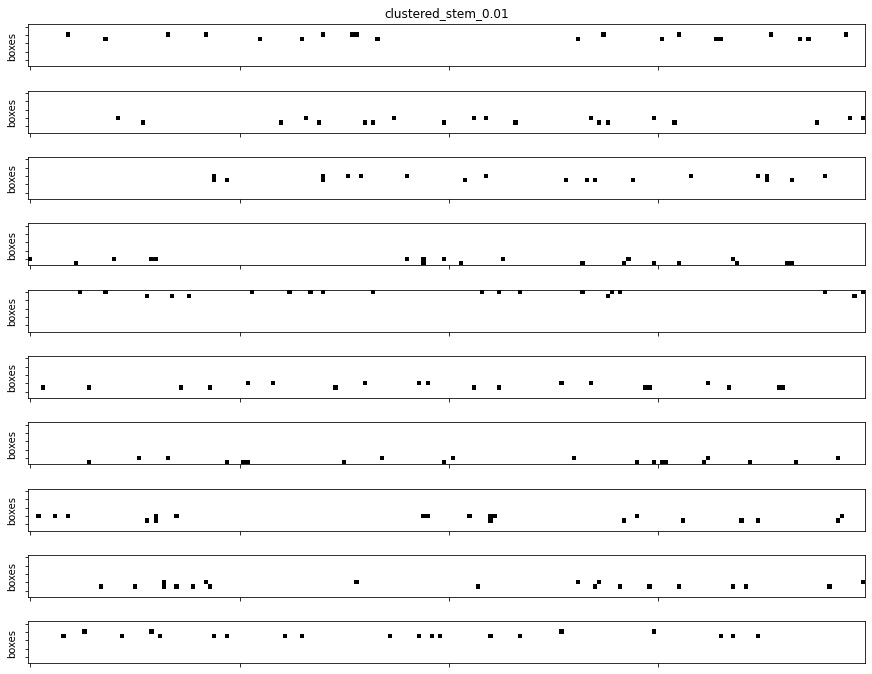

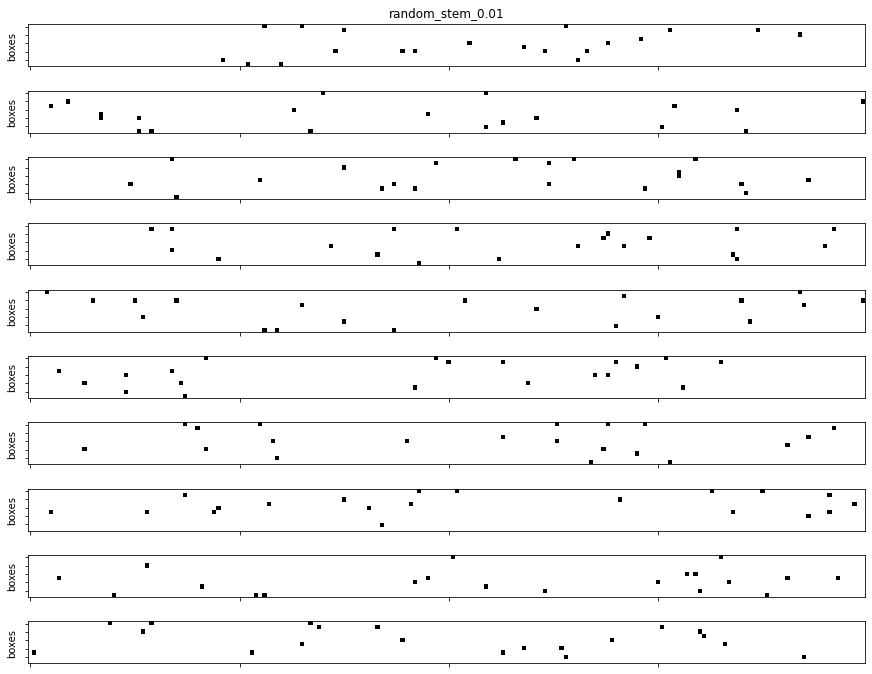

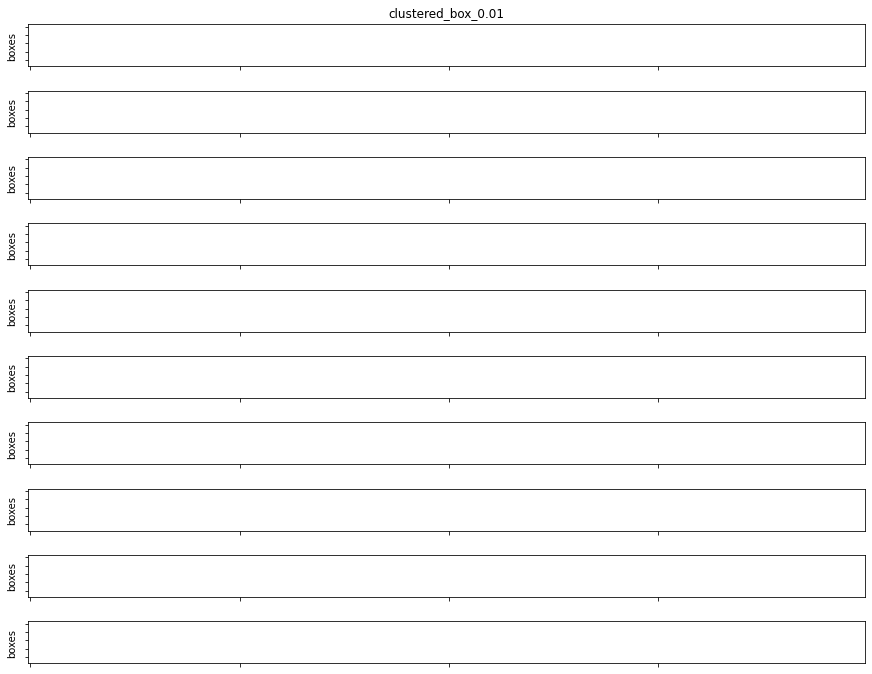

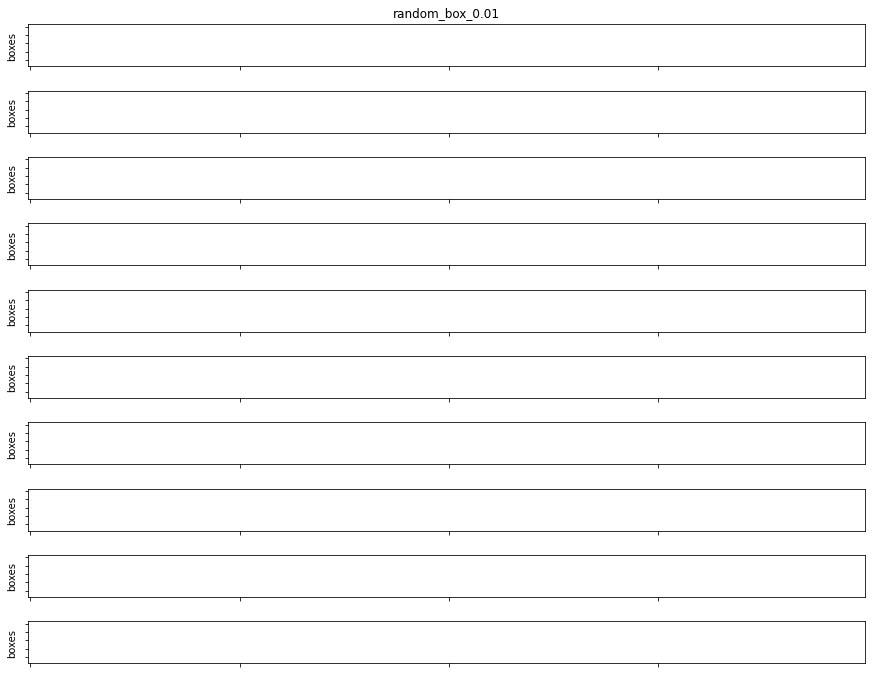

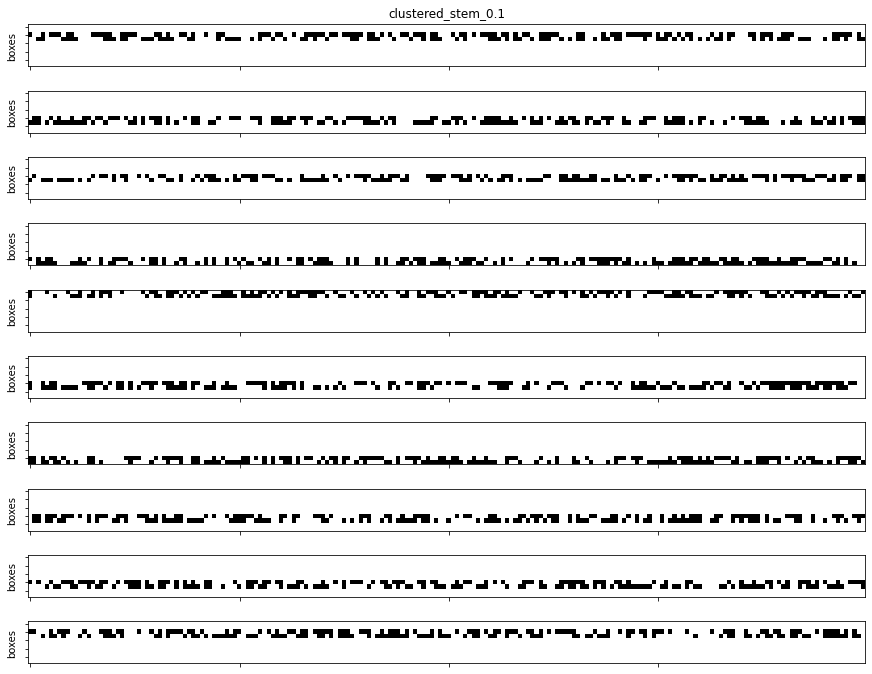

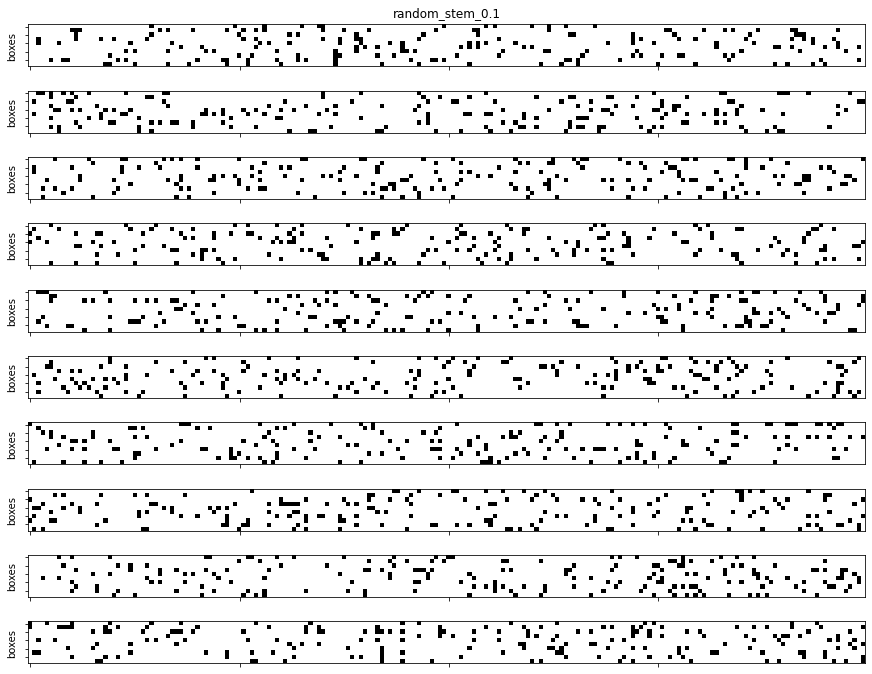

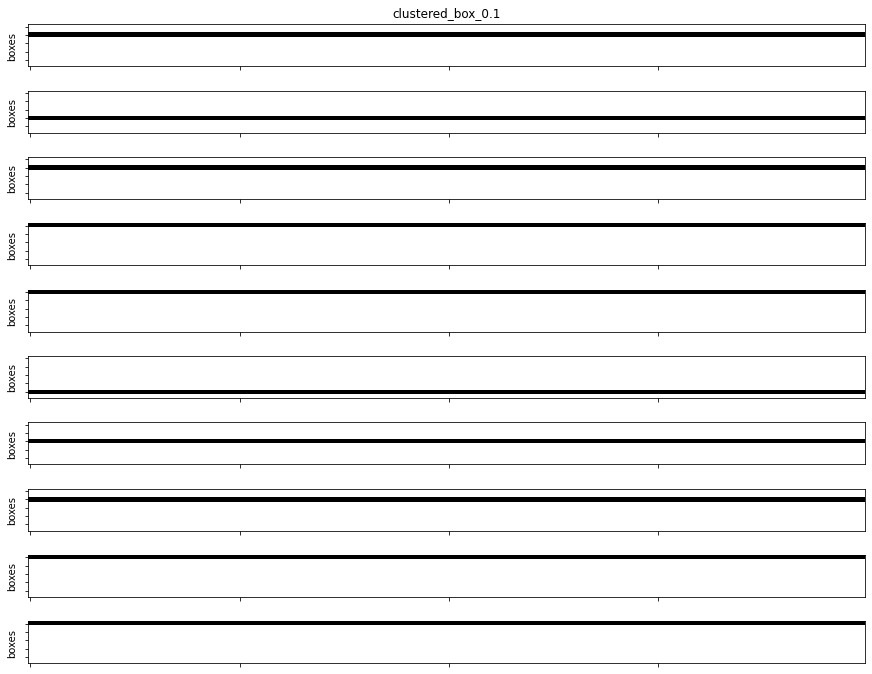

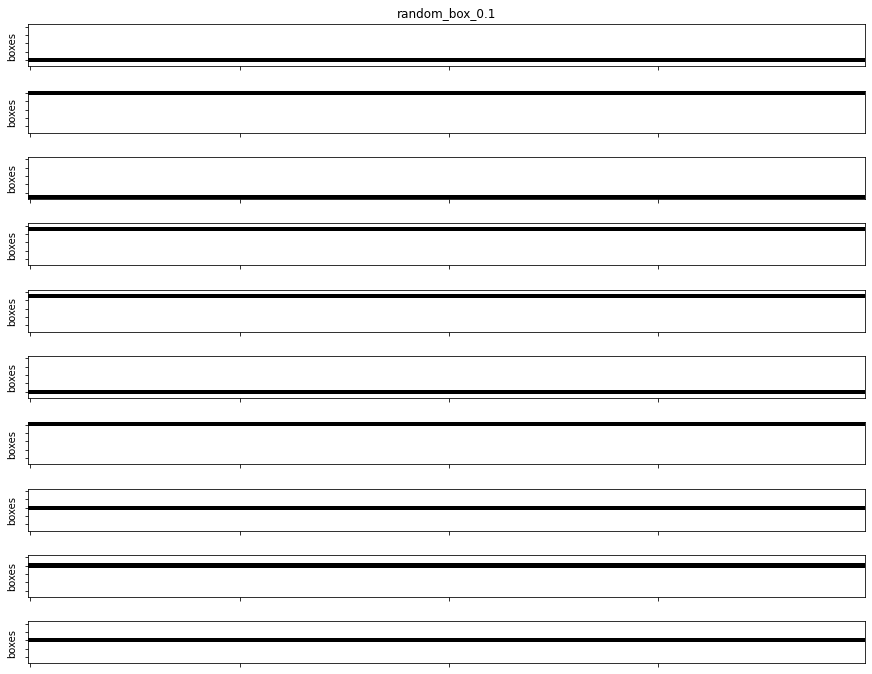

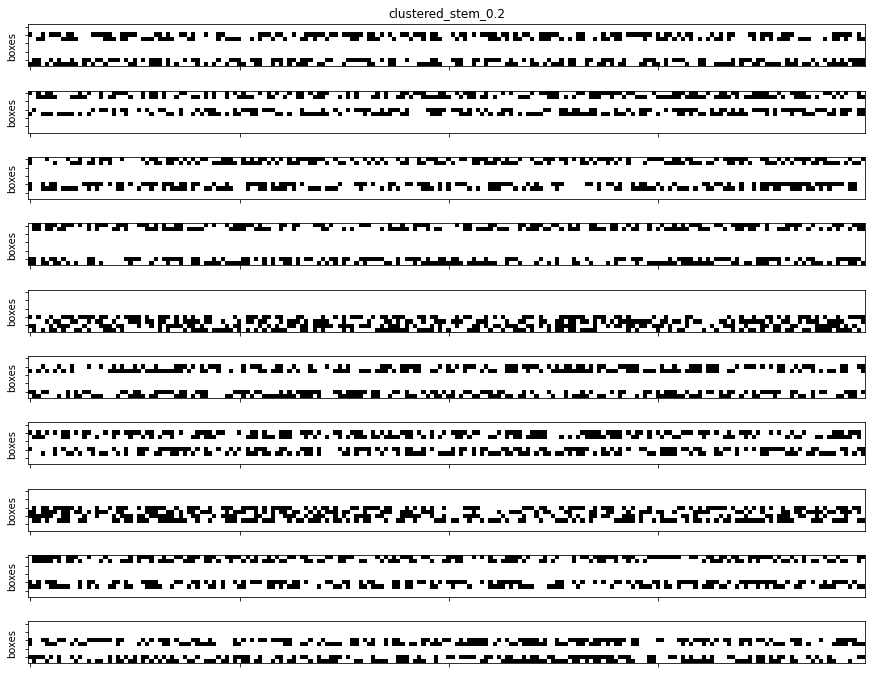

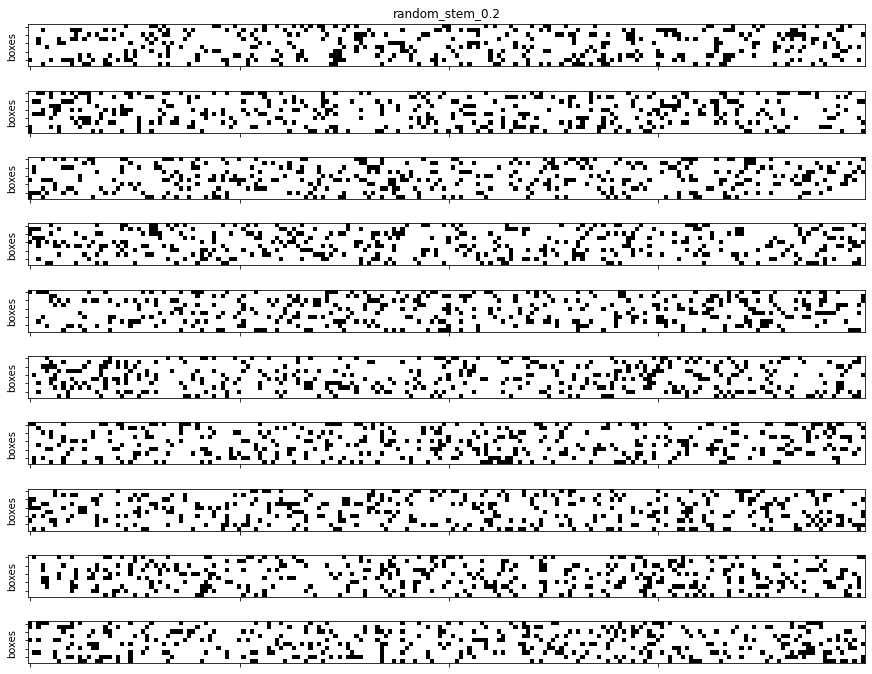

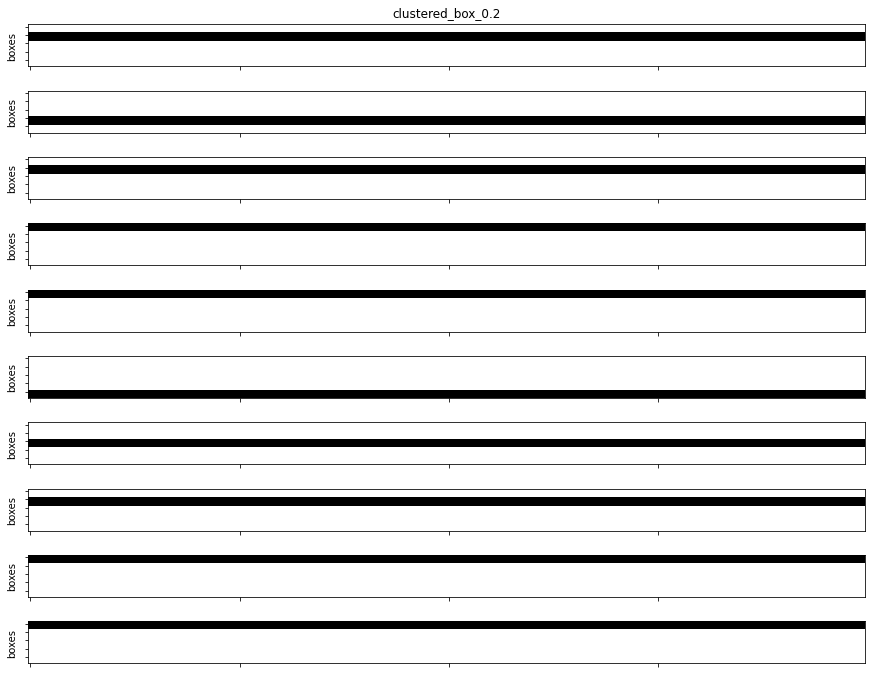

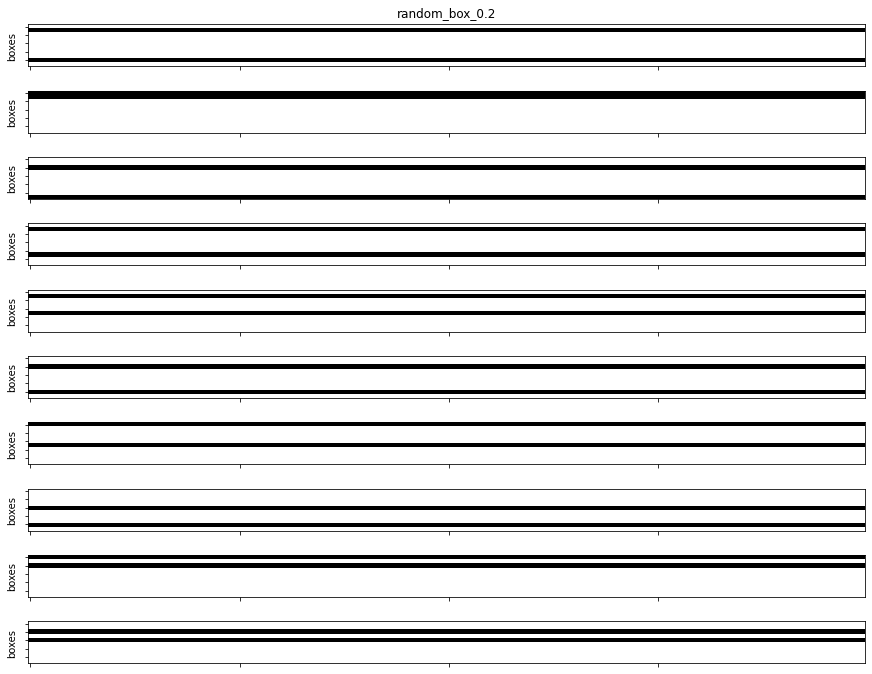

In [15]:
# Plot stems for each scenario and check pest arrangement and infestation unit

scenarios = infest_validation_df_1["shipment_name"]

for index, scenario in enumerate(scenarios):
    infest_validation_stems = np.stack(infest_validation_stems_unstacked[index])
    stems_by_shipment = np.vsplit(infest_validation_stems, num_shipments_1)
    fig, axs = plt.subplots(len(stems_by_shipment), figsize=(15,12))
    for i in range(len(stems_by_shipment)):
        axs[i].matshow(stems_by_shipment[i], cmap='Greys')
        axs[i].set_ylabel('boxes')
        #axs[i].set_xlabel('stems')
        axs[i].set_yticklabels([])
        axs[i].tick_params(labeltop=False, top=False)
        if i == 0:
            axs[i].set_title(scenario)

The shipments using stems as the infestation unit and clustered arrangement use maximum of 200 infested stems per cluster and are spread across 400 stems (2 boxes).

The shipments using boxes as the infestation unit and clustered arrangement use maximum 2 boxes per cluster.

# Sampling validation

### Test: Simulate 1 shipment, using 1 iteration.
Check sample size and indexes inspected using combinations of:
* Number of boxes - 10 or 100 (50 stems/box)
* Sampling unit - box or stems
* Sample size calculation method - proportion or hypergeometric
* Sample selection method - random, convenience, cluster interval (inspecting 10% of every 3rd box), or cluster random (inspecting 10% of random selected boxes)

In [49]:
num_shipments = 1
sample_validation_results, sample_validation_details = run_scenarios(
    config=basic_config,
    scenario_table=sample_validation_scenarios,
    seed=42,
    num_simulations=1,
    num_shipments=num_shipments,
    detailed=True,
)

Running scenario: sample_validation_1
Running scenario: sample_validation_2
Running scenario: sample_validation_3
Running scenario: sample_validation_4
Running scenario: sample_validation_5
Running scenario: sample_validation_6
Running scenario: sample_validation_7
Running scenario: sample_validation_8
Running scenario: sample_validation_9
Running scenario: sample_validation_10
Running scenario: sample_validation_11
Running scenario: sample_validation_12
Running scenario: sample_validation_13
Running scenario: sample_validation_14
Running scenario: sample_validation_15
Running scenario: sample_validation_16
Running scenario: sample_validation_17
Running scenario: sample_validation_18
Running scenario: sample_validation_19
Running scenario: sample_validation_20
Running scenario: sample_validation_21
Running scenario: sample_validation_22
Running scenario: sample_validation_23
Running scenario: sample_validation_24


In [52]:
sample_validation_df = save_scenario_result_to_pandas(
    sample_validation_results,
    config_columns=[
        "inspection_name",
        "shipment/boxes/min",
        "shipment/boxes/max",
        "shipment/stems_per_box/default",
        "inspection/unit",
        "inspection/sample_strategy",
        "inspection/proportion/value",
        "inspection/hypergeometric/detection_level",
        "inspection/selection_strategy",
    ],
    result_columns=[
        "avg_boxes_opened_completion",
        "avg_stems_inspected_completion",
    ],
)
sample_validation_df

,inspection_name,shipment/boxes/min,shipment/boxes/max,shipment/stems_per_box/default,inspection/unit,inspection/sample_strategy,inspection/proportion/value,inspection/hypergeometric/detection_level,inspection/selection_strategy,avg_boxes_opened_completion,avg_stems_inspected_completion
0,stem_hypergeometric_random,20,20,200,stems,hypergeometric,,0.05,random,20.0,58.0
1,stem_hypergeometric_tailgate,20,20,200,stems,hypergeometric,,0.05,tailgate,1.0,58.0
2,stem_hypergeometric_hierarchical_interval,20,20,200,stems,hypergeometric,,0.05,hierarchical,3.0,58.0
3,stem_hypergeometric_hierarchical_random,20,20,200,stems,hypergeometric,,0.05,hierarchical,3.0,58.0
4,stem_proportion_random,20,20,200,stems,proportion,0.02,,random,20.0,80.0
5,stem_proportion_tailgate,20,20,200,stems,proportion,0.02,,tailgate,1.0,80.0
6,stem_proportion_hierarchical_interval,20,20,200,stems,proportion,0.02,,hierarchical,4.0,80.0
7,stem_proportion_hierarchical_random,20,20,200,stems,proportion,0.02,,hierarchical,4.0,80.0
8,box_hypergeometric_random,20,20,200,boxes,hypergeometric,,0.05,random,19.0,3800.0
9,box_hypergeometric_tailgate,20,20,200,boxes,hypergeometric,,0.05,tailgate,19.0,3800.0


## Check sample sizes

In [58]:
expected_stem_sample_size = np.array([58, 58, 58, 58, 80, 80, 80, 80, 3800, 3800, 400, 400, 59, 59, 59, 59, 400, 400, 400, 400, 9000, 9000, 400, 400])
actual_stem_sample_size = sample_validation_df["avg_stems_inspected_completion"]
scenarios = sample_validation_df["inspection_name"]

sample_size_validatation = pd.DataFrame({"scenarios": scenarios, "expected_stem_sample_size": expected_stem_sample_size, "actual_stem_sample_size": actual_stem_sample_size})


In [59]:
sample_size_validatation

,scenarios,expected_stem_sample_size,actual_stem_sample_size
0,stem_hypergeometric_random,58,58.0
1,stem_hypergeometric_tailgate,58,58.0
2,stem_hypergeometric_hierarchical_interval,58,58.0
3,stem_hypergeometric_hierarchical_random,58,58.0
4,stem_proportion_random,80,80.0
5,stem_proportion_tailgate,80,80.0
6,stem_proportion_hierarchical_interval,80,80.0
7,stem_proportion_hierarchical_random,80,80.0
8,box_hypergeometric_random,3800,3800.0
9,box_hypergeometric_tailgate,3800,3800.0


The sample sizes are as expected.

## Check sample selection

In [60]:
sample_validation_inspected_indexes = [i[1] for i in sample_validation_details]

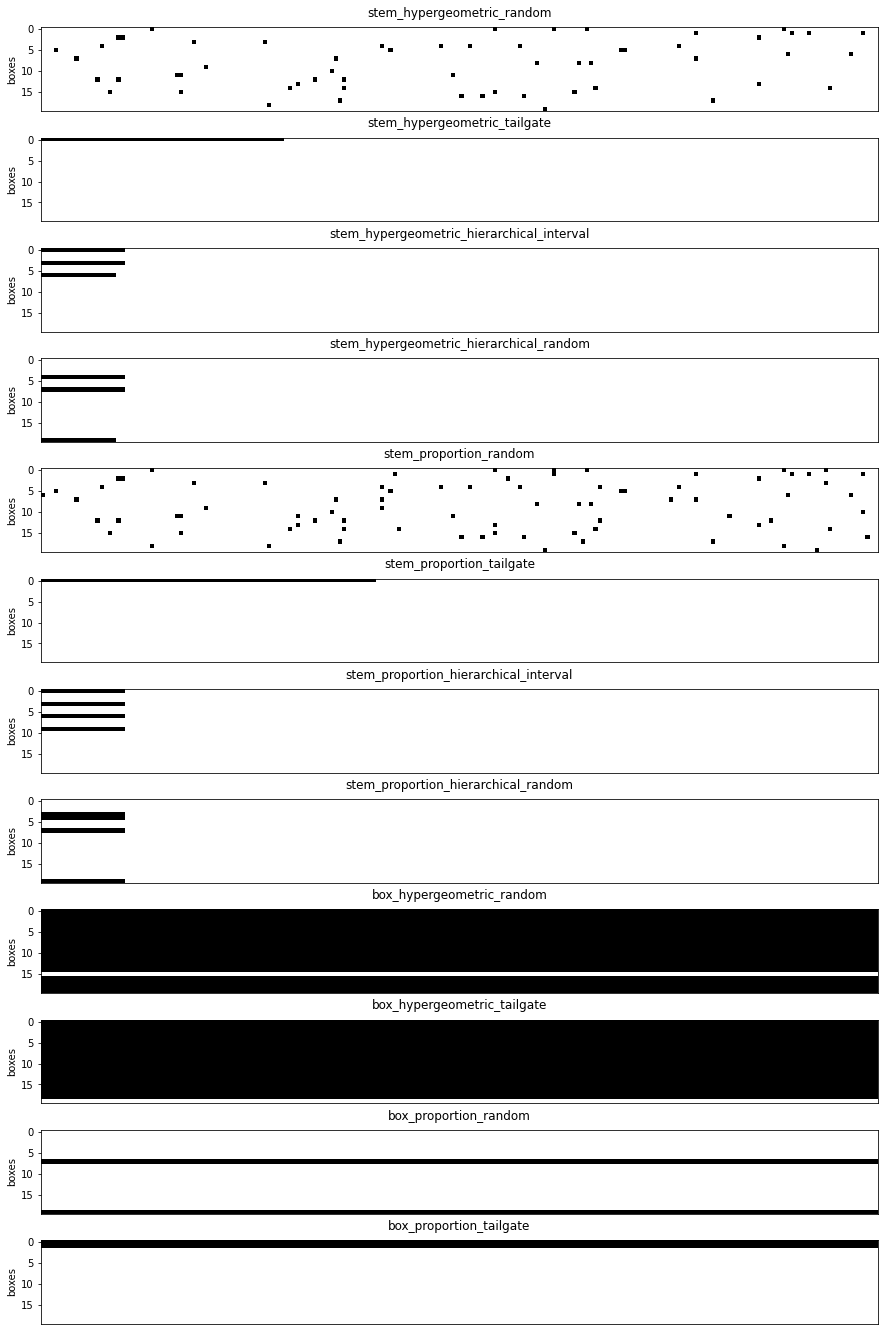

In [61]:
sample_scenarios = sample_validation_df[0:12]["inspection_name"]
num_stems_per_shipment = 4000
num_boxes_per_shipment = 20

fig, axs = plt.subplots(len(sample_scenarios), figsize=(15,24))
for i in range(len(sample_scenarios)):
    indexes = np.zeros(num_stems_per_shipment, dtype=np.int)
    inpsected = sample_validation_inspected_indexes[i][0]
    np.put(indexes, inpsected, 1)
    indexes = np.array_split(indexes, num_boxes_per_shipment)
    axs[i].matshow(indexes, cmap='binary', vmin=0, vmax=1)
    axs[i].set_ylabel('boxes')
    #axs[i].set_xlabel('stems')
    axs[i].tick_params(labeltop=False, top=False, bottom=False)
    axs[i].set_title(sample_scenarios[i])

The sample selection is as expected.

# Inspection outcome validation

### Test: Simulate 2000 shipments with 100 boxes each (200 stems/box), using 10 iterations.
Check inspection success rates using combinations of:
* Fixed infestation rates - fixed values of 0.01 and 0.1
* Infestation unit - box or stem
* Inspection unit - box or stem
* Sample size method - proportion (0.02 and 0.05) and hypergeometric (0.01, 0.05, 0.1 detection levels)
* Pest arrangement - random or clustered (box infestation unit: 2 boxes max infested units, stem infestation unit: 200 stems max infested units and 300 stems max width)

Calculate expected probability of detecting at least one contaminated unit using a binomial distribution for the proportion sampling and a hypergeometric distribution for the hypergeometric sampling.

Probabilities caculated using these online calculators: 

https://stattrek.com/online-calculator/binomial.aspx

https://stattrek.com/online-calculator/hypergeometric.aspx

In [45]:
num_shipments = 2000
outcome_validation_results = run_scenarios(
    config=basic_config,
    scenario_table=outcome_validation_scenarios,
    seed=42,
    num_simulations=10,
    num_shipments=num_shipments,
    detailed=False,
)

Running scenario: outcome_validation_1
Running scenario: outcome_validation_2
Running scenario: outcome_validation_3
Running scenario: outcome_validation_4
Running scenario: outcome_validation_5
Running scenario: outcome_validation_6
Running scenario: outcome_validation_7
Running scenario: outcome_validation_8
Running scenario: outcome_validation_9
Running scenario: outcome_validation_10
Running scenario: outcome_validation_11
Running scenario: outcome_validation_12
Running scenario: outcome_validation_13
Running scenario: outcome_validation_14
Running scenario: outcome_validation_15
Running scenario: outcome_validation_16
Running scenario: outcome_validation_17
Running scenario: outcome_validation_18
Running scenario: outcome_validation_19
Running scenario: outcome_validation_20
Running scenario: outcome_validation_21
Running scenario: outcome_validation_22
Running scenario: outcome_validation_23
Running scenario: outcome_validation_24
Running scenario: outcome_validation_25
Running s

In [46]:
outcome_validation_df = save_scenario_result_to_pandas(
    outcome_validation_results,
    config_columns=[
        "name",
        "shipment_name",
        "inspection_name",
        "pest/infestation_unit",
        "pest/infestation_rate/distribution",
        "pest/infestation_rate/value",
        "pest/arrangement",
        "inspection/unit",
        "inspection/sample_strategy",
    ],
    result_columns=[
        "false_neg",
        "intercepted",
        "total_missed_pests",
        "total_intercepted_pests",
        "avg_boxes_opened_completion",
        "avg_stems_inspected_completion",
    ],
)

## Check success rates

In [47]:
expected_success_rate = np.array([0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95, 0.999999, 0.19, 0.999999, 0.40951, 0.953004939, 0.952113444, 0.99802225, 0.998310334, 1, 1, 0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95, 0.982049447, 0.0199, 0.999956829, 0.04900995, 0.252981244, 0.25, 0.44779485, 0.45, 0.950071868, 0.95])

contaminated_shipments = outcome_validation_df["false_neg"] + outcome_validation_df["intercepted"]
actual_success_rate = outcome_validation_df["intercepted"] / contaminated_shipments
shipment_name = outcome_validation_df["shipment_name"]
inspection_name = outcome_validation_df["inspection_name"]

outcome_validatation = pd.DataFrame({"shipment_name": shipment_name, "inspection_name": inspection_name, "expected_success_rate": expected_success_rate, "actual_success_rate": actual_success_rate, "rate_difference": expected_success_rate - actual_success_rate})


In [48]:
outcome_validatation

,shipment_name,inspection_name,expected_success_rate,actual_success_rate,rate_difference
0,random_0.01,stems_proportion_0.02,0.982049,0.98300,-0.000951
1,random_0.01,boxes_proportion_0.02,0.019900,0.02060,-0.000700
2,random_0.01,stems_proportion_0.05,0.999957,0.99995,0.000007
3,random_0.01,boxes_proportion_0.05,0.049010,0.04905,-0.000040
4,random_0.01,stems_hypergeometric_0.1,0.252981,0.24855,0.004431
5,random_0.01,boxes_hypergeometric_0.1,0.250000,0.25210,-0.002100
6,random_0.01,stems_hypergeometric_0.05,0.447795,0.45460,-0.006805
7,random_0.01,boxes_hypergeometric_0.05,0.450000,0.44720,0.002800
8,random_0.01,stems_hypergeometric_0.01,0.950072,0.95030,-0.000228
9,random_0.01,boxes_hypergeometric_0.01,0.950000,0.95005,-0.000050


The inspection outcomes are very close to expected when using a random pest arrangement. 

The last half of the outcome vaildation scenarions use a clustered pest arrangement. When the infestation rate is low (0.01), the success rates are still very close to the scenarions with random arrangement. When the infestation rate is increase, however, inspection success rates are much lower, which is expected.